In [1]:
import os
from dotenv import load_dotenv
import pandas as pd
import duckdb
from langchain_groq import ChatGroq
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.graph import StateGraph, START, END
from typing import Annotated, List, Literal
from langgraph.graph.message import add_messages
from typing_extensions import TypedDict
import glob
from langfuse.langchain import CallbackHandler
from langsmith import traceable  # ADD THIS LINE

load_dotenv()

# LangSmith setup (ADD THESE LINES)
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "sql_agent"  

langfuse_handler = CallbackHandler()

print(f"LangSmith Tracing Enabled: {os.getenv('LANGCHAIN_TRACING_V2')}")

LangSmith Tracing Enabled: true


In [2]:
data_folder = r"C:\Users\AkshayRedekar\Documents\POC-Excel-Capabilities\06-agentic_rag_with_dbtool\data\structured_files\test"
csv_files = glob.glob(os.path.join(data_folder, '**/*.csv'), recursive=True)
excel_files = glob.glob(os.path.join(data_folder, '**/*.xlsx'), recursive=True)
excel_files += glob.glob(os.path.join(data_folder, '**/*.xls'), recursive=True)
all_files = csv_files + excel_files
print(f"Files found: {len(all_files)}")

# Check if files exist
if len(all_files) == 0:
    raise FileNotFoundError(f"No CSV or Excel files found in '{data_folder}'. Please check the path and add data files.")

# Display found files
for file in all_files:
    print(f"  - {os.path.basename(file)}")

Files found: 1
  - organizations.csv


In [3]:
def load_file(file_path):
    """Load CSV or Excel file into a pandas DataFrame"""
    try:
        if file_path.endswith('.csv'):
            return pd.read_csv(file_path)
        elif file_path.endswith(('.xlsx', '.xls')):
            return pd.read_excel(file_path)
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
    return None

print("File loading function defined!")

File loading function defined!


In [4]:
# Define the database file path
db_file_path = "./db/test.duckdb"  # Change this to your desired path

# Create directory if it doesn't exist
os.makedirs(os.path.dirname(db_file_path), exist_ok=True)

# Connect to DuckDB file (creates file if doesn't exist)
duckdb_connection = duckdb.connect(db_file_path)

table_info = {}
all_file_info = []

for file_path in all_files:
    dataframe = load_file(file_path)
    if dataframe is not None:
        table_name = os.path.splitext(os.path.basename(file_path))[0].replace(' ', '_').replace('-', '_')
        
        # Register DataFrame and create table in DuckDB
        duckdb_connection.register('temp_df', dataframe)
        duckdb_connection.execute(f"CREATE OR REPLACE TABLE {table_name} AS SELECT * FROM temp_df")
        duckdb_connection.unregister('temp_df')
        
        table_info[table_name] = dataframe.columns.tolist()
        all_file_info.append({
            'table_name': table_name,
            'columns': dataframe.columns.tolist(),
            'total_rows': len(dataframe),
            'file_path': file_path
        })

print(f"Database ready: {len(table_info)} tables")
print(f"Database saved to: {db_file_path}")

Database ready: 1 tables
Database saved to: ./db/test.duckdb


In [5]:
sql_schema = "Available Tables and Columns:\n\n"
for info in all_file_info:
    sql_schema += f"Table: {info['table_name']}\n"
    sql_schema += f"Columns: {', '.join(info['columns'])}\n"
    sql_schema += f"Total Rows: {info['total_rows']}\n\n"

print(sql_schema)

Available Tables and Columns:

Table: organizations
Columns: Index, Organization Id, Name, Website, Country, Description, Founded, Industry, Number of employees
Total Rows: 100




In [6]:
def close_database():
    """Close the DuckDB connection"""
    global duckdb_connection
    if duckdb_connection:
        duckdb_connection.close()
        print(f"Database connection closed: {db_file_path}")

def reopen_database():
    """Reopen existing DuckDB database"""
    global duckdb_connection
    duckdb_connection = duckdb.connect(db_file_path)
    print(f"Database connection reopened: {db_file_path}")
    
def get_database_info():
    """Get information about tables in the database"""
    tables = duckdb_connection.execute("SHOW TABLES").fetchall()
    print("\nTables in database:")
    for table in tables:
        print(f"  - {table[0]}")
    return tables

def load_existing_schema():
    """Load schema information from existing database"""
    global table_info, all_file_info, sql_schema
    
    tables = duckdb_connection.execute("SHOW TABLES").fetchall()
    table_info = {}
    all_file_info = []
    
    for table in tables:
        table_name = table[0]
        # Get column information
        columns_query = f"DESCRIBE {table_name}"
        columns = duckdb_connection.execute(columns_query).fetchall()
        column_names = [col[0] for col in columns]
        
        # Get row count
        row_count = duckdb_connection.execute(f"SELECT COUNT(*) FROM {table_name}").fetchone()[0]
        
        table_info[table_name] = column_names
        all_file_info.append({
            'table_name': table_name,
            'columns': column_names,
            'total_rows': row_count,
            'file_path': 'N/A (loaded from existing database)'
        })
    
    # Regenerate SQL schema description
    sql_schema = "Available Tables and Columns:\n\n"
    for info in all_file_info:
        sql_schema += f"Table: {info['table_name']}\n"
        sql_schema += f"Columns: {', '.join(info['columns'])}\n"
        sql_schema += f"Total Rows: {info['total_rows']}\n\n"
    
    print(f"Loaded schema from existing database: {len(table_info)} tables")
    return table_info

print("Database management functions defined!")

# Optional: View database info
get_database_info()

Database management functions defined!

Tables in database:
  - organizations


[('organizations',)]

In [7]:
@traceable
def run_sql_query(question: str, retry_count: int = 0) -> str:
    """Execute SQL query based on natural language question"""
    if retry_count > 2:
        return "Unable to generate valid SQL query after multiple attempts"
    
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
    
    prompt = f"""Generate ONLY a valid DuckDB SQL query. No explanations, no markdown, no extra text.

{sql_schema}

Question: {question}

Return ONLY the SQL query without any formatting or code blocks."""
    
    response = llm.invoke([HumanMessage(content=prompt)])
    sql_query = response.content.strip()
    
    # Clean up SQL query
    sql_query = sql_query.replace("```sql", "").replace("```", "").strip()
    
    lines = sql_query.split('\n')
    clean_lines = []
    for line in lines:
        line = line.strip()
        if line and not line.startswith('--') and not line.startswith('#'):
            clean_lines.append(line)
    sql_query = ' '.join(clean_lines)
    
    sql_query = sql_query.split(';')[0].strip()
    
    try:
        # Execute query with DuckDB
        result = duckdb_connection.execute(sql_query).fetchall()
        columns = [desc[0] for desc in duckdb_connection.description]
        
        result_text = f"SQL Query: {sql_query}\n\nResults ({len(result)} rows):\n"
        result_text += f"Columns: {', '.join(columns)}\n\n"
        
        for row in result[:20]:
            result_text += str(row) + "\n"
        
        return result_text
    except Exception as e:
        print(f"SQL Error (Attempt {retry_count + 1}): {str(e)}")
        return run_sql_query(question, retry_count + 1)

print("SQL query execution function defined!")

SQL query execution function defined!


In [8]:
class AgentState(TypedDict):
    messages: Annotated[List, add_messages]
    sql_context: str
    answer: str
    reflection: str
    retry_count: int

print("Agent state defined!")

Agent state defined!


In [9]:
@traceable(run_type="tool", name="execute_sql_node")
def execute_sql(state: AgentState):
    """Node to execute SQL query"""
    print("[SQL EXECUTION]")
    
    query = state["messages"][0].content
    sql_context = run_sql_query(query)
    
    return {"sql_context": sql_context}

print("Execute SQL node defined!")

Execute SQL node defined!


In [10]:
@traceable
def generate_answer(state: AgentState):
    """Node to generate answer from SQL results"""
    print("[GENERATE ANSWER]")
    
    sql_context = state.get("sql_context", "")
    question = state["messages"][0].content
    
    system_msg = f"""Answer the question using the SQL query results provided.

Database Schema:
{sql_schema}

Be concise, accurate, and base your answer only on the data provided."""
    
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
    
    response = llm.invoke(
        [
            SystemMessage(content=system_msg),
            HumanMessage(content=f"SQL Results: {sql_context}\n\nQuestion: {question}")
        ],
        config={"callbacks": [langfuse_handler]}
    )
    
    return {"answer": response.content}

print("Generate answer node defined!")

Generate answer node defined!


In [11]:
@traceable
def reflect_answer(state: AgentState):
    """Node to reflect on answer quality"""
    print("[REFLECTION]")
    
    question = state["messages"][0].content
    answer = state["answer"]
    
    prompt = f"""Evaluate if the answer properly addresses the question.

Question: {question}

Answer: {answer}

Respond with ONLY 'GOOD' if the answer is satisfactory, or 'RETRY' if it needs improvement."""
    
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0)
    result = llm.invoke(
        [HumanMessage(content=prompt)],
        config={"callbacks": [langfuse_handler]}
    )
    
    retry_count = state.get("retry_count", 0)
    
    return {
        "reflection": result.content,
        "retry_count": retry_count + 1
    }

print("Reflect answer node defined!")

Reflect answer node defined!


In [12]:
@traceable
def finalize(state: AgentState):
    """Node to finalize the answer"""
    print("[FINALIZE]")
    
    final_msg = AIMessage(content=state["answer"])
    return {"messages": [final_msg]}

print("Finalize node defined!")

Finalize node defined!


In [13]:
def route_after_reflection(state: AgentState) -> Literal["execute_sql", "finalize"]:
    """Determine next node based on reflection"""
    retry_count = state.get("retry_count", 0)
    reflection = state.get("reflection", "")
    
    if "good" in reflection.lower():
        return "finalize"
    elif retry_count < 2:
        return "execute_sql"
    else:
        return "finalize"

print("Routing function defined!")

Routing function defined!


In [14]:
workflow = StateGraph(AgentState)

# Add nodes
workflow.add_node("execute_sql", execute_sql)
workflow.add_node("generate_answer", generate_answer)
workflow.add_node("reflect_answer", reflect_answer)
workflow.add_node("finalize", finalize)

# Add edges
workflow.add_edge(START, "execute_sql")
workflow.add_edge("execute_sql", "generate_answer")
workflow.add_edge("generate_answer", "reflect_answer")

workflow.add_conditional_edges(
    "reflect_answer",
    route_after_reflection,
    {
        "execute_sql": "execute_sql",
        "finalize": "finalize"
    }
)

workflow.add_edge("finalize", END)

# Compile the graph
graph = workflow.compile()

print("✅ SQL Agent Graph ready!")

✅ SQL Agent Graph ready!


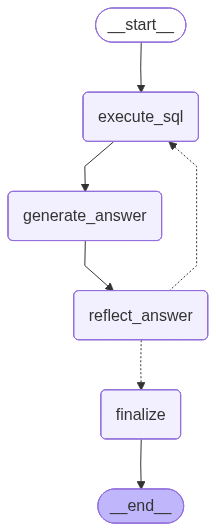

In [15]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(f"Graph visualization not available: {e}")

In [16]:
@traceable
def run_query_pipeline(question: str):
    """Main pipeline to run a query through the agent"""
    result = graph.invoke(
        {"messages": [HumanMessage(content=question)]},
        config={"callbacks": [langfuse_handler]}
    )
    return result['messages'][-1].content

# Execute queries
questions = [
    "What is the total number of rows in the dataset?",
    # "Show me the first 5 records",
    # "What are all the column names in the tables?"
]

for question in questions:
    print(f"\n{'='*60}")
    print(f"Question: {question}")
    print('='*60)
    
    answer = run_query_pipeline(question)
    print(f"\nAnswer:\n{answer}")


Question: What is the total number of rows in the dataset?
[SQL EXECUTION]
[GENERATE ANSWER]
[REFLECTION]
[FINALIZE]

Answer:
The total number of rows in the dataset is 100.
